# 1. Intro

For an intro and more context about this project click <a href="https://github.com/4rn3/rl_school_project#readme">here<a/>

# 2. Algorithms & setup

In [1]:
import os, time, random
from collections import deque
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation, Monitor

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, Input, MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

random.seed(1337)
RANDOM_SEED = 1337
tf.random.set_seed(RANDOM_SEED)
tf.compat.v1.GPUOptions(allow_growth=True)

print(gym.__version__)
print(tf.__version__) #2.10 last version to support GPU on win
print(tf.config.list_physical_devices('GPU'))

0.19.0
2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
env = gym.make("SpaceInvaders-v4")
env = GrayScaleObservation(env,keep_dim=True)
env = ResizeObservation(env, (84,84)) #resize
env = FrameStack(env, 4) #gain extra info by combining multiple frames i.e is mario landing or jumping

In [3]:
print("Observation space: ", env.observation_space.shape)
print("# Actions: ", env.action_space.n)
print("Available actions: ", env.get_action_meanings())

Observation space:  (4, 84, 84, 1)
# Actions:  6
Available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [109]:
stacked, height, width, channels = env.observation_space.shape
actions = env.action_space.n

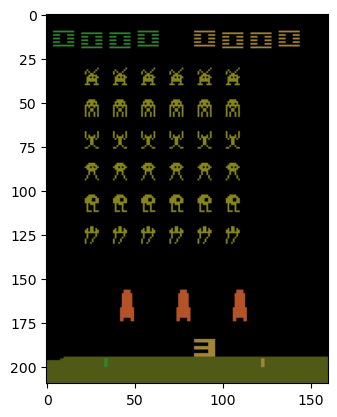

In [4]:
env_screen = env.render(mode = 'rgb_array')
plt.imshow(env_screen)

In [5]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
   
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.savefig(f"./plots/{title}.jpg")
    plt.show()

# 2.1 DQN

In [70]:
#hyp
TRAIN_EPISODE = 200
TEST_EPISODE = 10
LR = 1e-4
MEM_LEN = 50000
BATCH_SIZE = 500
UPDATE_TARGET_TRESHOLD = 5
AGGREGATE_STATS = 5
MODEL_NAME = "DQN"
MIN_REPLAY_SIZE = 1000

#Bellman hyp
EPSILON = 1
MAX_EPSILON = 1
MIN_EPSILON = 0.01
DECAY = 0.03
BEL_LR = 0.7
DISCOUNT = 0.66

In [107]:
def agent(state_shape, action_shape):
    
    model = Sequential()
    #Feature generation
    model.add(Conv2D(32, (8,8), strides=(4,4), activation='relu', input_shape=(stacked, height, width, channels)))
    model.add(Conv2D(64, (4,4), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    #Dim reduction
    model.add(Flatten())
    #FC classifier
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    
    model.compile(loss="mse", optimizer=Adam(learning_rate=LR), metrics=['accuracy'])    
    return model

In [110]:
model = agent(env.observation_space.shape, env.action_space.n) #init prediction model
target_model = agent(env.observation_space.shape, env.action_space.n) #init target model
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=MEM_LEN) #init memory

In [111]:
def batch_train(env, replay_memory, model, target_model, done):
    learning_rate = BEL_LR
    discount_factor = DISCOUNT
    
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return
    batch_size = BATCH_SIZE
    mini_batch = random.sample(replay_memory, batch_size)
    
    #Predicting the Q-values
    current_states = np.array([transition[0] for transition in mini_batch]) #add current_state from minibatch
    current_qs_list = model.predict(current_states, verbose=0)

    new_current_states = np.array([transition[3]for transition in mini_batch]) #add new_current_state from minibatch
    future_qs_list = target_model.predict(new_current_states, verbose=0)
  
    X, y = [], []

   #Updating Q-values
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward
            
        #Bellman
        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
        
        X.append(observation)
        y.append(current_qs)
    
    model.fit(np.array(X), np.array(y), batch_size=batch_size, verbose=0, shuffle=False)

In [ ]:
#Train loop
X, y, Total_rewards, time_tracking = [], [], [], []

steps_to_update_target_model = 0

total_start = time.time()

for episode in trange(TRAIN_EPISODE):
    n_steps_episode = 0
    total_training_rewards = 0
    ep_rewards = []

    observation = env.reset()
    done = False
    
    while not done:
        #track time
        start = time.time()
        
        steps_to_update_target_model += 1
        random_number = np.random.rand()
        #Exploration
        if random_number <= EPSILON:
            action = env.action_space.sample()
        #Exploitation    
        else:
            predicted = model.predict(np.array(observation), verbose=0).flatten()
            action = np.argmax(predicted)

        new_observation, reward, done, info = env.step(action)
        total_training_rewards += reward
        ep_rewards.append(reward)
        
        replay_memory.append([observation, action, reward, new_observation, done])

        #Update prediction model
        if steps_to_update_target_model % 4 == 0 or done:
            batch_train(env, replay_memory, model, target_model, done)
        
        observation = new_observation
        
        n_steps_episode += 1
        
        if done:
            stop = time.time()
            time_tracking.append(stop-start)
            
            print('{} Total training rewards: {} after n steps = {}'.format(episode, total_training_rewards, n_steps_episode))
            Total_rewards.append(total_training_rewards)

            #Update target model
            if steps_to_update_target_model >= UPDATE_TARGET_TRESHOLD:
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break
    
    #Update epsilon 
    EPSILON = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY * episode)
    
    avg_score = np.mean(Total_rewards[-100:])
    #Save model and metrics
    if episode % AGGREGATE_STATS == 0:
        avg_ep_reward = round(sum(ep_rewards)/len(ep_rewards),2)
        min_ep_reward = min(ep_rewards)
        max_ep_reward = max(ep_rewards)
        avg_time = round(sum(time_tracking)/len(time_tracking),2) #avg time for aggregate amount of episodes
        
        model.save(f'./models/DQN_models/{avg_score}_{str(episode)}_{MODEL_NAME}.h5')
        
        with open(f"./logs/DQN_logs/DQN.txt","a") as f:
            f.write(f"{avg_ep_reward},{min_ep_reward},{max_ep_reward},{avg_score},{avg_time},{round(EPSILON,2)},{str(episode)}\n")
        
        time_tracking = []
env.close()
total_stop = time.time()
total_time = total_stop-total_start

  0%|          | 0/100 [00:00<?, ?it/s]

0 Total training rewards: 60.0 after n steps = 463
1 Total training rewards: 135.0 after n steps = 756


 2:51:36 100episodes

In [ ]:
#Plot trainig
plot_res(Total_rewards,'DQN_train2')

<p>We see an ascending trend with the highest reward around episode 90-95</p>

### 2.1.1 Log analytics

In [14]:
dqn_df = pd.read_csv('./logs/DQN_logs/DQN.csv')
dqn_df.sort_values(by=["avg_ep_reward","max_ep_reward","avg_total_rewards"], ascending=False).head(5)

,avg_ep_reward,min_ep_reward,max_ep_reward,avg_total_rewards,avg_time,epsilon,episode
21,0.49,0.0,200.0,176.05,1.12,0.05,105
20,0.48,0.0,200.0,174.45,0.96,0.06,100
19,0.25,0.0,30.0,165.10,0.88,0.07,95
4,0.25,0.0,30.0,163.81,0.23,0.55,20
7,0.24,0.0,30.0,169.17,0.45,0.36,35


In [18]:
#Highest (non averaged) total rewards
dqn_df[dqn_df["episode"].isin([85,90,95])]

,avg_ep_reward,min_ep_reward,max_ep_reward,avg_total_rewards,avg_time,epsilon,episode
17,0.18,0.0,30.0,154.07,0.75,0.09,85
18,0.12,0.0,25.0,155.05,0.82,0.08,90
19,0.25,0.0,30.0,165.10,0.88,0.07,95


<AxesSubplot:>

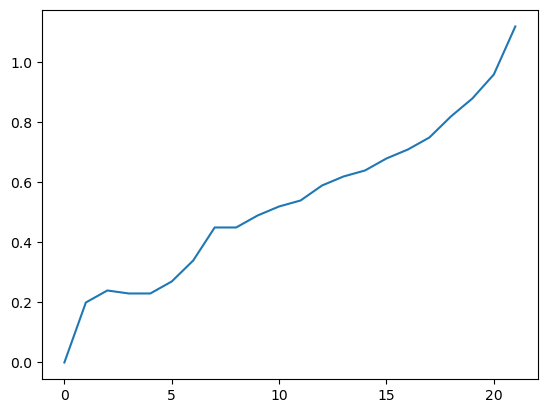

In [27]:
dqn_df["avg_time"].plot.line()

In [52]:
dqn_df.sort_values(by=["avg_time"], ascending=False).head(5)

,avg_ep_reward,min_ep_reward,max_ep_reward,avg_total_rewards,avg_time,epsilon,episode
21,0.49,0.0,200.0,176.05,1.12,0.05,105
20,0.48,0.0,200.0,174.45,0.96,0.06,100
19,0.25,0.0,30.0,165.10,0.88,0.07,95
18,0.12,0.0,25.0,155.05,0.82,0.08,90
17,0.18,0.0,30.0,154.07,0.75,0.09,85


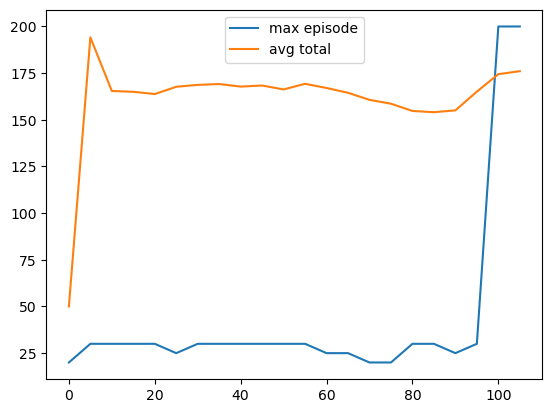

In [36]:
plt.plot(dqn_df["episode"], dqn_df["max_ep_reward"], label="max episode")
plt.plot(dqn_df["episode"], dqn_df["avg_total_rewards"], label="avg total")
plt.legend(loc="best")
plt.show()

<p>It looks like the average total reward scores good early on because on episode 5 we had a high reward which skewed the results for the early episodes</p>

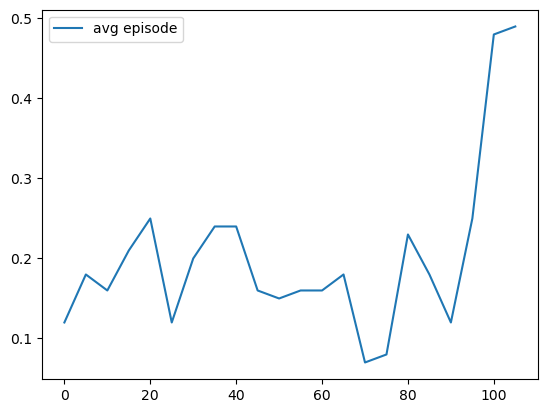

In [37]:
plt.plot(dqn_df["episode"], dqn_df["avg_ep_reward"], label="avg episode")
plt.legend(loc="best")
plt.show()

### 2.1.2 Evaluation

<p>Let's compare the model with the highest avg reward (episode 105) and the model with highest max reward (95)</p>

In [75]:
### Load models
best_avg_model = "0.25_60_DQN.h5"
best_avg_model = load_model(os.path.join("./models/DQN_models",best_avg_model), compile=False)

best_max_model = "165.1_95_DQN.h5"
best_max_model = load_model(os.path.join("./models/DQN_models",best_max_model), compile=False)

In [76]:
epochs, avg_rewards = 0, 0
observation = env.reset()
done = False

while not done:
    
    observation = tf.convert_to_tensor(observation)
    observation = tf.expand_dims(observation, 0)
    
    predicted = best_avg_model.predict(np.array(observation), verbose=0).flatten()
    action = np.argmax(predicted)
    observation, reward, done, info = env.step(action)
    env.render()
    avg_rewards  += reward
    epochs += 1
    
env.close()
print(f"Reward: {avg_rewards}") 

Reward: 140.0


In [78]:
epochs, best_max_reward = 0, 0
observation = env.reset()
done = False

while not done:
    
    observation = tf.convert_to_tensor(observation)
    observation = tf.expand_dims(observation, 0)
    
    predicted = best_max_model.predict(np.array(observation), verbose=0).flatten()
    action = np.argmax(predicted)
    observation, reward, done, info = env.step(action)
    env.render()
    best_max_reward  += reward
    epochs += 1
    
env.close()
print(f"Reward: {best_max_reward}") 

Reward: 285.0


<p>We see that the model with the highest max reward learned to stick to the left of the screen and just spam the shoot button</p>

In [68]:
best_max_model = "165.1_95_DQN.h5"
best_dqn_model = load_model(os.path.join("./models/DQN_models",best_max_model), compile=False)

In [71]:
#Evaluate model
Total_reward = []
for episode in trange(TEST_EPISODE):
        n_steps_episode = 0
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            
            observation = tf.convert_to_tensor(observation)
            observation = tf.expand_dims(observation, 0)
            
            predicted = best_dqn_model.predict(observation, verbose=0)
            action = np.argmax(predicted)
            new_observation, reward, done, info = env.step(action)
            total_training_rewards += reward  
            observation = new_observation
            
            n_steps_episode += 1
        print('{} Reward = {}'.format(episode,total_training_rewards))
        Total_reward.append(total_training_rewards)
env.close()

  0%|          | 0/10 [00:00<?, ?it/s]

0 Reward = 285.0
1 Reward = 285.0
2 Reward = 285.0
3 Reward = 285.0
4 Reward = 240.0
5 Reward = 285.0
6 Reward = 285.0
7 Reward = 260.0
8 Reward = 285.0
9 Reward = 285.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


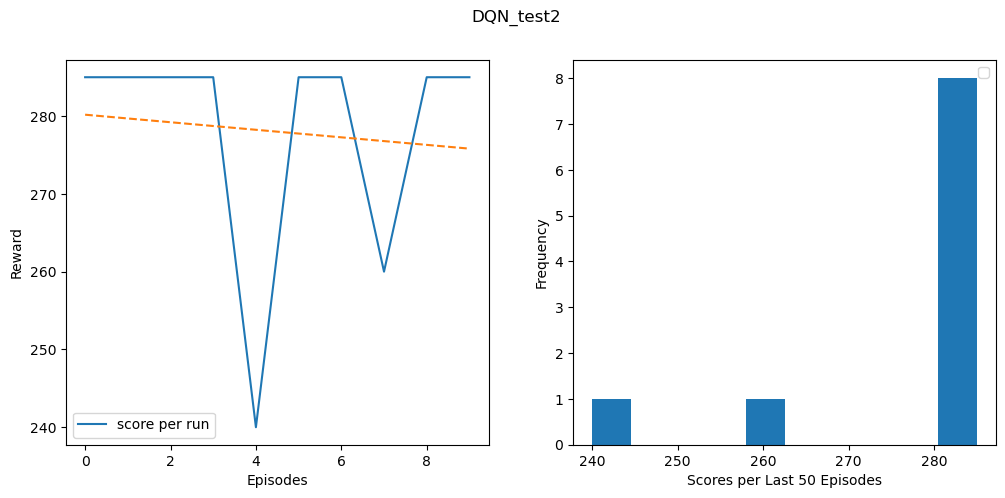

In [72]:
plot_res(Total_reward,'DQN_test2')

# 2.2 Actor-Critic

In [99]:
#hyp
TRAIN_EPISODE = 100
TEST_EPISODE = 10
LR = 1e-3
GOAL = 300
AGGREGATE_STATS = 5
MAX_STEPS_PER_EPISODEE = 10000
MODEL_NAME = "AC"
GAMMA = 0.99 
EPS = np.finfo(np.float32).eps.item() #smallest number such that 1.0 + eps != 1.0

In [84]:
# Define the different layers
inputs = Input(shape=env.observation_space.shape[1:])

common = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
common = MaxPooling2D(pool_size=(2, 2))(common)

common = Conv2D(32, kernel_size=(3, 3), activation='relu')(common)
common = MaxPooling2D(pool_size=(2, 2))(common)

common = Conv2D(32, kernel_size=(3, 3), activation='relu')(common)
common = MaxPooling2D(pool_size=(2, 2))(common)

common = Flatten()(common)

actor = Dense(env.action_space.n, activation="softmax")(common)
critic = Dense(1)(common)

# Construct the model
model = keras.Model(inputs=inputs, outputs=[actor, critic])
print(model.summary())

# Add adam optimizer and Huber loss
optimizer = keras.optimizers.Adam(learning_rate=LR)
huber_loss = keras.losses.Huber()

model.compile(optimizer=optimizer, loss=huber_loss)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 82, 82, 32)   320         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 41, 41, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 39, 39, 32)   9248        ['max_pooling2d_3[0][0]']        
                                                                                            

In [100]:
action_probs_history = []
critic_value_history = []
rewards_history = []
score_history = []

average_reward = 0
episode_count = 0

total_start = time.time()
while True:
    state = env.reset()
    episode_reward = 0
    time_tracking = []
    ep_rewards = []
    with tf.GradientTape() as tape:
        for timestep in range(1, MAX_STEPS_PER_EPISODEE):
            start_time = time.time()
            
            state = tf.convert_to_tensor(state)
            
            action_probs, critic_value = model(state)
            
            p = np.squeeze(action_probs)
            
            action = np.random.choice(env.action_space.n, p=p[0])
            action_probs_history.append(tf.math.log(action_probs[0, action]))
            
            critic_value_history.append(critic_value[0, 0])

            state, reward, done, info = env.step(action)
            
            rewards_history.append(reward)
            episode_reward += reward
            
            if done:
                stop_time = time.time()
                time_tracking.append(stop_time-start_time)
                break
        
        score_history.append(episode_reward)
        ep_rewards.append(episode_reward)
        
        # Calculate expected value from rewards
        G = np.zeros_like(rewards_history)
        for t in range(len(rewards_history)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards_history)):
                G_sum += rewards_history[k]*discount
                discount *= GAMMA
            G[t] = G_sum
        
        # normalize
        G = np.array(G)
        G = (G - np.mean(G)) / (np.std(G) + EPS)
        G = G.tolist()
        
        history = zip(action_probs_history, critic_value_history, G)

        actor_losses = []
        critic_losses = []
        
        for log_prob, value, rew in history:
            diff = rew - value
            #update actor
            actor_losses.append(-log_prob * diff) # actor loss
            #update critic
            critic_losses.append(huber_loss(tf.expand_dims(value, 0), tf.expand_dims(rew, 0)))
        
        ## Combine losses
        loss_value = sum(actor_losses) + sum(critic_losses)
        
        grads = tape.gradient(loss_value, model.trainable_variables)
        
        #backprop
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
        

    episode_count += 1
    
    avg_score = np.mean(score_history[-100:])
    
     #Save model and metrics
    if episode_count % AGGREGATE_STATS == 0:
        print(f"episode: {episode_count}, avg score: {round(avg_score,2)}")
        avg_ep_reward = round(sum(ep_rewards)/len(ep_rewards),2)
        min_ep_reward = min(ep_rewards)
        max_ep_reward = max(ep_rewards)
        avg_time = round(sum(time_tracking)/len(time_tracking),2) #avg time for aggregate amount of episodes
        
        model.save(f'./models/AC_models/{round(avg_score,2)}_{str(episode_count)}_{MODEL_NAME}.h5')
        
        with open(f"./logs/AC_logs/AC.txt","a") as f:
            f.write(f"{avg_ep_reward},{max_ep_reward},{min_ep_reward},{round(avg_score,2)},{episode_count}\n")
            
    if avg_score > GOAL:
        model.save(f'./models/AC_models/{avg_score}_{str(episode_count)}_{MODEL_NAME}.h5')
        print("Solved at episode {}!".format(episode_count))
        break
                    
total_stop = time.time()
total_time = total_stop-total_start
total_time

episode: 5, avg score: 270.0
episode: 10, avg score: 270.0
episode: 15, avg score: 270.0
episode: 20, avg score: 270.0
episode: 25, avg score: 270.0
episode: 30, avg score: 270.0
episode: 35, avg score: 270.0
episode: 40, avg score: 270.0
episode: 45, avg score: 270.0


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


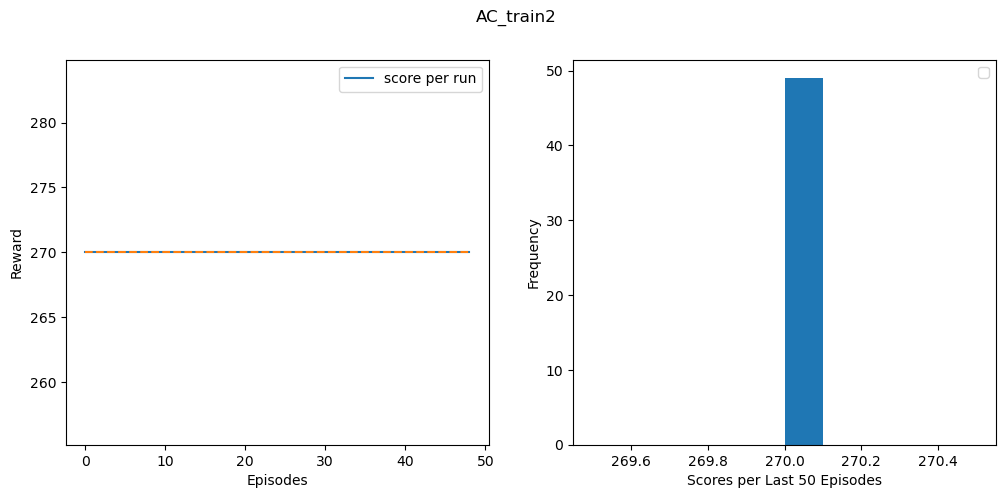

In [101]:
plot_res(score_history,'AC_train2')

### 2.2.1 Log analytics

In [92]:
ac_df = pd.read_csv('./logs/AC_logs/AC.csv')
ac_df.drop("G",axis=1, inplace=True)
ac_df.head()

avg_ep_reward  \
20.0 20.0 20.0 24.0 5  [-0.5350444542099919 -0.53501 -0.534975 -0.53494 -0.534905 -0.534869 -0.534833 -0.534796 -0.534759 -0.534722 -0.534684 -0.534646 -0.534607 -0.534569 -0.534529 -0.53449 -0.53445 -0.534409 -0.534368 -0.534327 -0.534285 -0.534243 -0.534201 -0.534158 -0.534114 -0.534071 -0.534026 -0.533982 -0.533936 -0.533891 -0.533845 -0.533798 -0.533751 -0.533703 -0.533656 -0.533607 -0.533558 -0.533509 -0.533459 -0.533408 -0.533357 -0.533306 -0.533254 -0.533201 -0.533148 -0.533095 -0.53304 -0.532986 -0.532931 -0.532875 -0.532818 -0.532761 -0.532704 -0.532646 -0.532587 -0.532528 -0.532468 -0.532408 -0.532347 -0.532285 -0.532223 -0.53216 -0.532096 -0.532032 -0.531967 -0.531901 -0.531835 -0.531768 -0.531701 -0.531633 -0.531564 -0.531494 -0.531424 -0.531353 -0.531281 -0.531209 -0.531135 -0.531061 -0.530987 -0.530911 -0.530835 -0.530758 -0.53068 -0.530602 -0.530523 -0.530442 -0.530362 -0.53028 -0.530197 -0.530114 -0.53003 -0.529945 -0.529859 -0.529772 -0.529684 -0.529595 -0.529506 -0.529416 -0.529324 -0.529232 -0.529139 -0.529045 -0.52895 -0.528854 -0.528757 -0.528659 -0.52856 -0.52846 -0.528359 -0.528257 -0.528154 -0.52805 -0.527945 -0.527839 -0.527732 -0.527623 -0.527514 -0.527403 -0.527292 -0.527179 -0.527065 -0.52695 -0.526834 -0.526716 -0.526598 -0.526478 -0.526357 -0.526235 -0.526111 -0.525987 -0.525861 -0.525734 -0.525605 -0.525475 -0.525344 -0.525212 -0.525078 -0.524943 -0.524807 -0.524669 -0.524529 -0.524389 -0.524247 -0.524103 -0.523958 -0.523812 -0.523664 -0.523515 -0.523364 -0.523211 -0.523057 -0.522902 -0.522745 -0.522586 -0.522426 -0.522264 -0.5221 -0.521935 -0.521768 -0.5216 -0.521429 -0.521257 -0.521084 -0.520908 -0.520731 -0.520552 -0.520371 -0.520188 -0.520004 -0.519818 -0.519629 -0.519439 -0.519247 -0.519053 -0.518857 -0.518659 -0.518459 -0.518257 -0.518053 -0.517847 -0.517639 -0.517429 -0.517216 -0.517002 -0.516785 -0.516566 -0.516345 -0.516122 -0.515896 -0.515669 -0.515438 -0.515206 -0.514971 -0.514734 -0.514494 -0.514252 -0.514008 -0.513761 -0.513511 -0.513259 -0.513005 -0.512748 -0.512488 -0.512226 -0.511961 -0.511693 -0.511423 -0.51115 -0.510874 -0.510596 -0.510314 -0.51003 -0.509743 -0.509453 -0.50916 -0.508864 -0.508565 -0.508263 -0.507958 -0.50765 -0.507339 -0.507025 -0.506707 -0.506387 -0.506063 -0.505736 -0.505405 -0.505071 -0.504734 -0.504393 -0.504049 -0.503702 -0.503351 -0.502996 -0.502638 -0.502276 -0.501911 -0.501542 -0.501169 -0.500792 -0.500412 -0.500028 -0.499639 -0.499247 -0.498851 -0.498451 -0.498047 -0.497639 -0.497227 -0.49681 -0.49639 -0.495965 -0.495536 -0.495102 -0.494664 -0.494222 -0.493775 -0.493324 -0.492868 -0.492408 -0.491942 -0.491473 -0.490998 -0.490519 -0.490035 -0.489545 -0.489051 -0.488552 -0.488048 -0.487539 -0.487025 -0.486505 -0.485981 -0.485451 -0.484915 -0.484374 -0.483828 -0.483276 -0.482719 -0.482156 -0.481587 -0.481013 -0.480433 -0.479847 -0.479255 -0.478657 -0.478053 -0.477443 -0.476826 -0.476204 -0.475575 -0.47494 -0.474298 -0.47365 -0.472996 -0.472335 -0.471667 -0.470992 -0.470311 -0.469622 -0.468927 -0.468225 -0.467515 -0.466799 -0.466075 -0.465344 -0.464605 -0.463859 -0.463106 -0.462345 -0.461576 -0.4608 -0.460015 -0.459223 -0.458422 -0.457614 -0.456798 -0.455973 -0.45514 -0.454298 -0.453448 -0.452589 -0.451722 -0.450846 -0.449961 -0.449067 -0.448164 -0.447252 -0.446331 -0.4454 -0.44446 -0.443511 -0.442552 -0.441583 -0.440605 -0.439616 -0.438618 -0.43761 -0.436591 -0.435562 -0.434523 -0.433473 -0.432413 -0.431341 -0.430259 -0.429167 -0.428063 -0.426948 -0.425821 -0.424684 -0.423534 -0.422374 -0.421201 -0.420017 -0.41882 -0.417612 -0.416391 -0.415158 -0.413913 -0.412655 -0.411384 -0.410101 -0.408804 -0.407495 -0.406172 -0.404836 -0.403486 -0.402123 -0.400746 -0.399355 -0.397949 -0.39653 -0.395097 -0.393649 -0.392186 -0.390708 -0.389216 -0.387709 -0.386186 -0.384648 -0.383094 -0.381525 -0.37994 -0.378339 -0.376721 -0.375088 -0.373438 -0.371771 -0.370087 -0.368386 -0.366668 -0.364933 -0.363181 -0.36141 -0.359622 -0.357815 -0.355991 -0.354148 -0.352

### 2.2.2 Evaluation

In [102]:
### Load the best model
best_ac_model = "270.0_45_AC.h5"
best_ac_model = load_model(os.path.join("./models/AC_models",best_ac_model), compile=False)

In [ ]:
score_history = []
n_episodes = 100
for i in range(n_episodes):
        done = False
        score = 0
        observation = env.reset()
        
        while not done:
            
            observation = tf.convert_to_tensor(observation)
            observation = tf.expand_dims(observation, 0)
            
            action_probs, critic_value = model(observation)
            action = np.random.choice(2, p=np.squeeze(action_probs))
            observation, reward, done, info = env.step(action)
            score += reward
        
        score_history.append(score)
        
        avg_score = np.mean(score_history[-100:])
        if i % 10 == 0:
            print('episode ', i,  'avg score %.1f' % avg_score)

In [ ]:
plot_res(Total_reward,'AC_test')

### 3 Comparison

### 3.1 Models compared to random actions

In [98]:
#play 1 game with random actions
epochs, rndm_rewards = 0, 0

observation = env.reset()
done = False


while not done:
    
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    env.render()
    rndm_rewards  += reward
    epochs += 1
    time.sleep(0.1)
    
env.close()
print(f"Reward: {rndm_rewards}")

Reward: 110.0


In [97]:
#play 1 game of the dqn best model
epochs, dqn_rewards = 0, 0
observation = env.reset()
done = False

while not done:
    
    observation = tf.convert_to_tensor(observation)
    observation = tf.expand_dims(observation, 0)
    
    predicted = best_dqn_model.predict(np.array(observation), verbose=0).flatten()
    action = np.argmax(predicted)
    observation, reward, done, info = env.step(action)
    env.render()
    dqn_rewards  += reward
    epochs += 1
    
env.close()
print(f"Reward: {dqn_rewards}") 

Reward: 285.0


In [103]:
#play 1 game of the ac best model
epochs, ac_rewards = 0, 0
observation = env.reset()
done = False

while not done:
    state = tf.convert_to_tensor(state)
            
    action_probs, critic_value = best_ac_model(state)

    p = np.squeeze(action_probs)

    action = np.random.choice(env.action_space.n, p=p[0])
    
    action = np.argmax(predicted)
    observation, reward, done, info = env.step(action)
    env.render()
    ac_rewards  += reward
    epochs += 1
    
    time.sleep(0.01)
    
env.close()
print(f"Reward: {ac_rewards}") 

Reward: 285.0


### 3.2 Anaylitical comparison